In [51]:
import os
import sys
import numpy as np
import scipy.interpolate

import matplotlib.pyplot as plt

In [72]:
def shapedfilter_hrtf(sdelay, freq, gain, fs, ctap, ctap2):
    """
    """
    sdelay = sdelay.reshape((-1, 1)) # Ensure sdelay is an M x 1 matrix
    assert np.all(sdelay >= 0), "The sample delay must be positive"
    ntaps = 2 * ctap - 1
    N = ctap - 1
    fc = 0.9
    # Design the non-integer delay filter
    x = np.ones((1, ntaps))
    x[0, 0] = 0
    x = np.matmul(np.ones(sdelay.shape), np.arange(-N, N + 1).reshape((1, -1))) - np.matmul(sdelay, x)
    h = 0.5 * fc * (1 + np.cos(np.pi * x / N)) * np.sinc(fc * x)
    freq = freq.reshape((-1)) # Ensure freq is a vector
    if ctap2 > 1:
        df = np.arange(0, ctap2) * (np.pi / (ctap2 - 1)) # Determine FFT points
        freq = np.array([-np.spacing(1)] + list(2 * np.pi * freq) + [np.pi])
        gain = np.concatenate([gain[:, :1], gain, gain[:, -1:]], axis=1)
        # Interpolate reflection frequency-dependence to get gains at FFT points
        G = scipy.interpolate.interp1d(freq.reshape([-1]), gain)(df)
        # Combine the non-integer delay filter and the wall/sphere filter
        G[:, ctap2-1] = np.real(G[:, ctap2-1])
        # Transform into appropriate wall transfer function
        G = np.concatenate([G, np.conj(G[:, 1:ctap2-1])[:, ::-1]], axis=1)
        gt = np.real(np.fft.ifft(G.T, axis=0))
        # Zero-pad and FFT
        g = np.concatenate([
            0.5 * gt[(ctap2-1):(ctap2), :],
            gt[ctap2 : (2 * ctap2 - 2), :],
            gt[0 : ctap2 - 1, :],
            0.5 * gt[(ctap2-1):(ctap2), :],
            np.zeros((2 * ctap - 2, gt.shape[1])),
        ], axis=0)
        G = np.fft.fft(g, axis=0)
        # Zero-pad and FFT the delay filter
        H = np.fft.fft(
            np.concatenate([
                h.T,
                np.zeros((2 * ctap2 - 2, gt.shape[1])),
            ], axis=0),
            axis=0
        )
        # Convolve wall transfer function and delay filter
        HOUT = H * G
        # Obtain total impulse response
        hout = np.real(np.fft.ifft(HOUT, axis=0)).T
    else:
        # Scale impulse response only if wall reflections are
        # frequency-independent and sphere is not present
        hout = h * np.matmul(gain[:, 0], np.ones(h[0:1, :].shape))
    return hout


sdelay = np.array([0.411119294090895, 0.600165773186745])
gain = np.array([
    [0.013462743344629,0.056313514709473,0.137448031335961,0.278500976009402,0.483982307179293,0.664832635991501],
    [0.008750783174009,0.042235136032104,0.112707385695488,0.245080858888274,0.450103545676742,0.638239330551840],
])
freq = np.array([0.002834467120181,0.005668934240363,0.011337868480726,0.022675736961451,0.045351473922902,0.090702947845805])
fs = 44100
ctap = 11
ctap2 = 33
hout = shapedfilter_hrtf(sdelay, freq, gain, fs, ctap, ctap2)


(2, 6)
(2, 6) (2, 21)


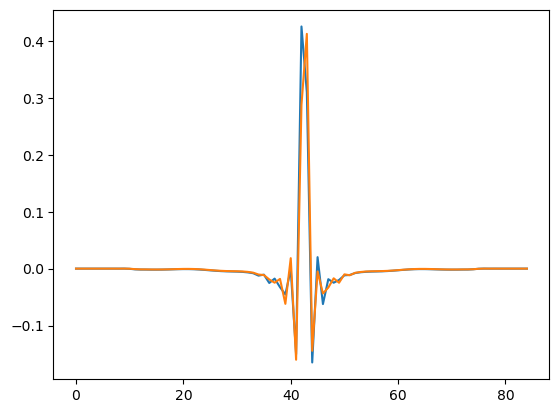

In [73]:
fig, ax = plt.subplots()
ax.plot(hout.T)
plt.show()